<h1><center>Stroke Prediction</center></h1>
<center>September 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Notebook Preparation
    1. Motivation and Objectives
    1. Dataset
1. Data Cleaning
    1. Duplicate rows
    1. Datatypes
    1. Unique values
    1. Missing values
1. EDA
    1. Distribution
    1. Missing Values
    1. Correlation
        1. Correlation with numerical features
        1. Multicollinearity - Variance Inflation Factor
    1. Statistic Inference
        1. Target Population
        2. Transform 'AnnualIncome'
        3. Hypothesis Testing
1. Preprocessing
    1. Transformations
    1. Data Splitting
1. Models
    1. Apply various models
    1. Ensemble - Voting
1. Improvements

# 1. Project Introduction

## 1.1. Notebook Preparation

In [2]:
%%capture
%pip install -r requirements.txt

In [3]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eda import *

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import LabelEncoder

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (8, 5),
}
sns.set_theme(
    context="notebook", style="whitegrid", rc=custom_params
)
px.defaults.template = "seaborn"
pd.set_option("display.precision", 2)

%matplotlib inline

## 1.2. Motivations and Objectives

This project's objectives are: 
<br><br>
1. Practice performing EDA.
2. Practice applying statistical inference procedures.
3. Practice using various types of machine learning models.
4. Practice building ensembles of machine learning models.
5. Practice deploying machine learning models.

## 1.3. Dataset

Objective: Brief overview of our dataset, including the features and label

The dataset was downloaded from Kaggle, [Stroke_Prediction_Data](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
,<br>
on 10 September 2024. It will be used to predict whether a patient is likely
 <br> to get a stroke. <br>
The data contains 11 clinical features, like gender, age, smoking status, <br>
etc, that help describe each patient.

Features: <br>
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
<br>

Label: <br>
stroke: 1 if the patient had a stroke or 0 if not <br>

In [4]:
stroke_data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
display(stroke_data.head())
shape = stroke_data.shape
print(f'Number of rows: {shape[0]}\nNumber of columns: {shape[1]}')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Number of rows: 5110
Number of columns: 12


# 2.  Data cleaning
Objective:
1. Closer look at the values that consist of our data
2. Look out for duplicates, and missing and/or unusual values

## 2.1. Duplicate rows

In [5]:
print(stroke_data.id.duplicated().any())

False


After confirming there is no duplicated id number/cases, since id number 
should not be relevant information to base our prediction on, we can remove it.

In [6]:
stroke_data = stroke_data.drop(columns=['id'])

## 2.2. Datatypes

In [7]:
datatype_data = stroke_data.dtypes
datatype_data

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Certain features have unexpected datatypes, like age, hypertension, and 
heart_disease. Looking into the values itself will help clarify data types.

## 2.3. Unique values

In [8]:
stroke_data.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

Some features have unexpected amount of unique values. Looking into the 
values itself will help.<br>

In [9]:
for column in stroke_data.columns:
    df = stroke_data[column].value_counts()
    display(df)

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

age
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: count, Length: 104, dtype: int64

hypertension
0    4612
1     498
Name: count, dtype: int64

heart_disease
0    4834
1     276
Name: count, dtype: int64

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

avg_glucose_level
93.88     6
91.68     5
91.85     5
83.16     5
73.00     5
         ..
111.93    1
94.40     1
95.57     1
66.29     1
85.28     1
Name: count, Length: 3979, dtype: int64

bmi
28.7    41
28.4    38
26.7    37
27.6    37
26.1    37
        ..
48.7     1
49.2     1
51.0     1
49.4     1
14.9     1
Name: count, Length: 418, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

stroke
0    4861
1     249
Name: count, dtype: int64

Looking more into work_type registered as 'children', as the difference 
between 'children' and 'Never_worked' is not clear.

In [10]:
stroke_data[stroke_data.work_type=='children'].age.describe()

count    687.000000
mean       6.841339
std        4.533364
min        0.080000
25%        2.000000
50%        6.000000
75%       11.000000
max       16.000000
Name: age, dtype: float64

All labeled as children are <= 16 years old.

In [11]:
stroke_data[(stroke_data.age<=16)]['work_type'].value_counts()

work_type
children         687
Private           85
Never_worked      12
Self-employed      9
Govt_job           3
Name: count, dtype: int64

It is clear that not all under 16 year olds are labeled as 'children'. Some 
are 'Never_worked', and some are working. It is unclear why only part is 
labeled as 'children'. <br>However, it since this
 feature is to state their work status and 'children' in this context would 
 mean not working, we can consolidate 'children' into 'Never_worked'. <br>
 This would ensure consistency across all age groups, without losing the age
  information, as it is in the 'age' column.

In [12]:
stroke_data.loc[stroke_data['work_type'] == 'children', 'work_type'] = \
    'Never_worked'

## 2.4. Missing values

In [13]:
missing_values(df=stroke_data)

,Column,Missing Values,Percentage Missing
gender,gender,0,0.00
age,age,0,0.00
hypertension,hypertension,0,0.00
heart_disease,heart_disease,0,0.00
ever_married,ever_married,0,0.00
work_type,work_type,0,0.00
Residence_type,Residence_type,0,0.00
avg_glucose_level,avg_glucose_level,0,0.00
bmi,bmi,201,3.93
smoking_status,smoking_status,0,0.00


To properly impute missing values, it is necessary to first understand the 
sampling population and if the missing values belong to a specific subset of
 sampling population.

In [14]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Data Cleaning Insights:</b><br>
    1. There are no duplicated rows, and each row is identified by a unique ID.<br>
    2. The feature 'id' is irrelevant to our stroke prediction, so it was removed.<br>
    3. Consolidated 'children' work type to 'Never_worked'. <br>
    4. All missing values come from the 'bmi' feature, and further analysis 
    is needed to determine proper imputation methods.
</div>
''')

# 3. EDA

Objectives:
1. Data distribution
2. Check and handle outliers, missing values
3. Comparison and A/B test between data with and without stroke
4. Understand how our data is collect and possible bias

## 3.1. Distribution

Identify features, label, and different feature types.

In [15]:
target_name = 'stroke'
data, target = (stroke_data.drop(columns=[target_name]), 
                stroke_data[target_name])

In [16]:
categorical_columns_selector = selector(dtype_exclude='float64')
numerical_columns_selector = selector(dtype_include='float64')

categorical_columns = categorical_columns_selector(data)
numerical_columns = numerical_columns_selector(data)

**Numerical Features**

In [17]:
data[numerical_columns].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


Plotting boxplot over violin plot for numerical features to have a visual 
understanding of the overall distribution, range, and outliers.

AttributeError: 'NoneType' object has no attribute 'set_title'

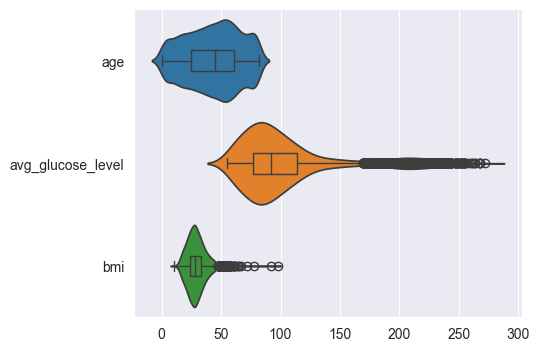

In [23]:
plt.figure(figsize=(5,4))
violin_boxplot(data=data, columns=numerical_columns, title='Numerical Data '
                                                           'Violin Box '
                                                           'Plot')

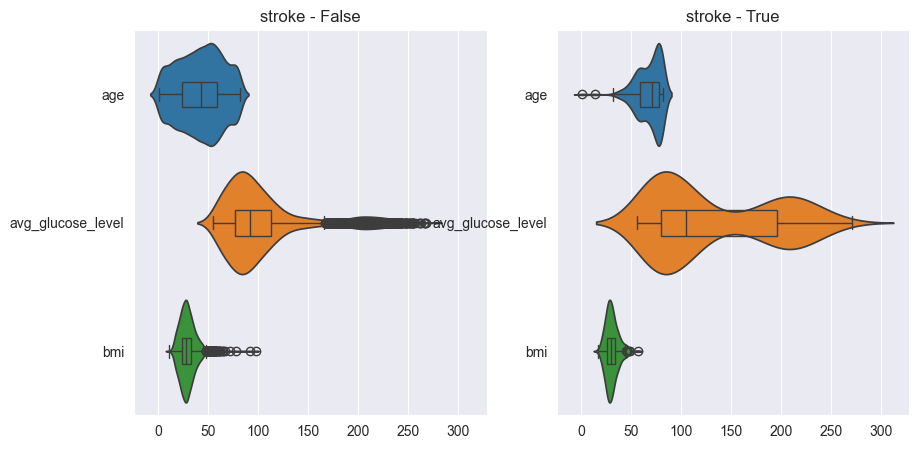

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)

violin_boxplot(data=stroke_data[stroke_data.stroke == 1], 
               columns=numerical_columns, title='stroke - True', ax=axes[1])
violin_boxplot(data=stroke_data[stroke_data.stroke == 0], 
               columns=numerical_columns, title='stroke - False', ax=axes[0])


**Categorical Features**

Represent categorical features in barplots, visualize unique values for each
 feature and their distribution in percentage.

In [ ]:
percentage_subplots(data=data, columns=categorical_columns, title='Categorical '
                                                             'data '
                                                             'Distribution',
               nrows=3, ncols=3)

**Target Variable**

Target variable and its distribution in percentage.

In [ ]:
percentage_subplots(data=stroke_data, columns=['stroke'], title='Target Variable')

In [ ]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Distribution Insights:</b><br>
    <i>numerical features...</i><br>
    1. Numerical features show very different ranges of values, signalling an 
    importance in scaling in future feature engineering.<br>
    2. Average Glucose Level has the most outliers, which can be justified 
    by the bimodal distribution. This shows 2 subpopulations, which could be 
    relevant to our stroke prediction. <br>
    3. 'age' includes children less than 1 year old, justifies why the 
    datatype is float.<br><br>
    
    <i>for categorical features...</i><br>
    4. Inconsistent labeling among categorical features, preprocessing 
    required before applying learning model.<br>
    5. Outlier responses in 'gender'.<br><br>
    
    <i>and the target variable...</i><br>
    6. Imbalanced dataset, with only 4.87% responding positively to stroke. 
    <br>
</div>
''')

## 3.2. Missing values

Objective: <br>
All missing values come from the 'bmi' feature. Determine proper treatment.

In [ ]:
stroke_data[numerical_columns].describe()

In [ ]:
stroke_data[stroke_data.bmi.isnull()][numerical_columns].describe()

In [ ]:
violin_boxplot(data=stroke_data[stroke_data.bmi.isnull()], 
               columns=numerical_columns, title='bmi missing - True ')

In [ ]:
sns.pairplot(stroke_data[numerical_columns])
plt.show()